O objetivo dessa primeira fase de avaliação de desempenho é determinar os níveis que trazem o melhor resultado para as métricas em questão considerando apenas os parâmetros: resolução das images e imagens pré-processadas ou não.

Pseudocódigo:

Para cada repetição no número de repetições: <br>
Para cada tipo de entrada (pré-processada ou não): <br>
Para cada tipo de resolução 256x256 e 512x512:
- Treinar computando métricas;
- Testar computando métricas;

Revisar ModelCheckpoint para salvar em results bonitinho;
Investigar pq valid step não salva as métricas bem;
Incluir tempo de treinamento e tempo de teste;
Revisar como funciona internamente o passo de validação;
Separar métricas também por classe!!!!;

### Setup

In [1]:
import torch
import gc
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))

from src.data import LOCCADataset  # noqa: E402, F401
from src.constants import BATCH_SIZE  # noqa: E402, F401
# from torchmetrics.segmentation import HausdorffDistance  # noqa: E402, F401

LOCCA_DIR = ROOT_DIR / 'datasets/locca'

volumes_paths = np.array(sorted(LOCCA_DIR.glob('images*/*/*.nii.gz'), key=lambda p:p.name))

##### Transformações

In [2]:
import albumentations as A

# Veja: https://albumentations.ai/docs/3-basic-usage/semantic-segmentation/
# De acordo com isso, ao especificar os parametros image e mask para transform, 
# algumas transformações que só fazem sentido serem aplicadas em imagens não serão
# aplicadas nas máscaras.

# Talvez, devido o pré-procesamento, não faça sentido o uso de transformações de intensidades dos pixels
train_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ToTensorV2(),
])


test_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.ToTensorV2(),
])

### Visualização

In [4]:
import random
from torch.utils.data import DataLoader


train_paths = list((ROOT_DIR / 'datasets/locca/pngs_preprocessed/images').glob('*.png'))
test_paths = list((ROOT_DIR / 'datasets/locca/pngs_preprocessed/test/images').glob('*.png'))



train_dataset = LOCCADataset(
    train_paths,
    train_transform
)

# val_dataset = LOCCADataset(
#     val_paths,
#     valid_transform
# )

test_dataset = LOCCADataset(
    test_paths,
    test_transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  #TODO: isso pode atrapalhar a avaliação de desempenho? Imagino que sim!
    num_workers=4,
)

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=4
# )

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)


In [5]:
loader = iter(train_loader)

In [6]:
batch = next(loader)
print(batch['volume'].shape)

torch.Size([8, 1, 512, 512])


In [8]:
def visualize_batch_overlay(batch, n_samples=4, alpha=0.5):
    volume = batch["volume"].squeeze(1)
    mask = batch["mask"]

    B = volume.shape[0]
    idxs = random.sample(range(B), min(n_samples, B))

    fig, axs = plt.subplots(len(idxs), 3, figsize=(6, 3 * len(idxs)))

    if len(idxs) == 1:
        axs = [axs]

    for lin, i in zip(axs, idxs):
        ct = volume[i].cpu().numpy()
        m = mask[i].cpu().numpy()

        lin[0].imshow(ct, cmap="gray")
        lin[0].set_title(f"slice [{i}]\nftype: {volume[i].cpu().dtype}")
        lin[0].axis("off")

        lin[1].imshow(m, cmap="Reds")
        lin[1].set_title(f"mask [{i}]\nvalues: {np.unique(m)}\ndtype: {mask[i].cpu().dtype}")
        lin[1].axis("off")

        lin[2].imshow(ct, cmap="gray")
        lin[2].imshow(m > 0, cmap="Reds", alpha=alpha)
        lin[2].set_title(f"Overlay slice [{i}]")
        lin[2].axis("off")

    plt.tight_layout()
    plt.show()

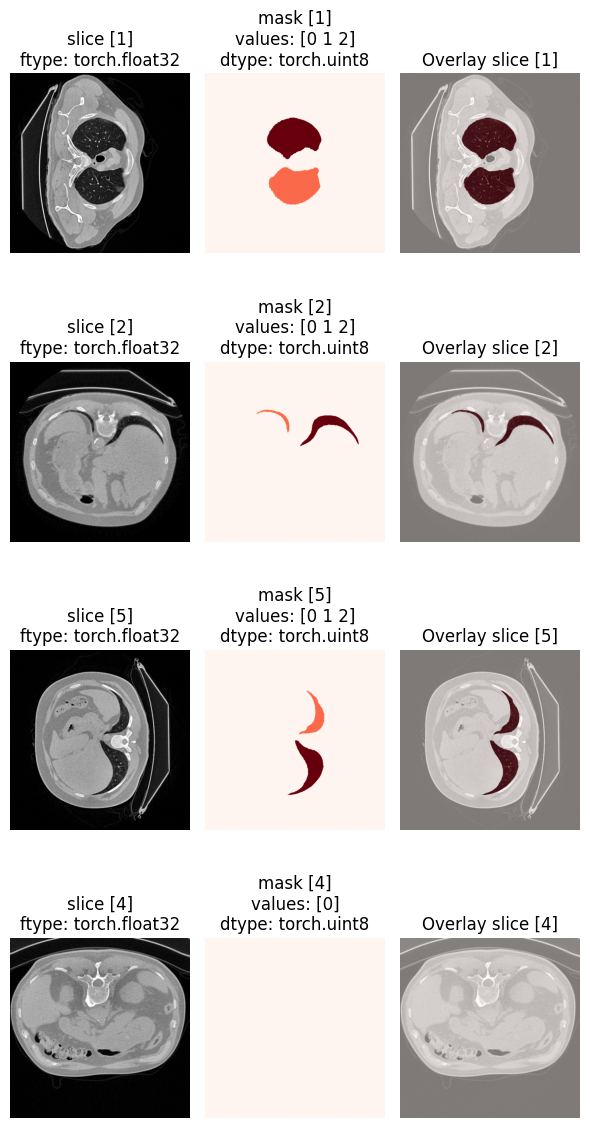

In [9]:
visualize_batch_overlay(batch)

### UNet++

Linghting Module
Baseado em: https://colab.research.google.com/github/qubvel-org/segmentation_models.pytorch/blob/main/examples/camvid_segmentation_multiclass.ipynb

In [3]:
from src.module import LOCCAModel, LOCCAModelFactory
from src.kfold import KFoldExecutor
from src.utils.checkpoint import SaveLastOrOnException

In [4]:
import pytorch_lightning as pl

arch="UnetPlusPlus"

model_factory = LOCCAModelFactory(
    arch=arch,
    encoder_name="mobilenet_v2",
    in_channels=1,
    out_classes=3,
    phase=1,
    model_kwargs={"encoder_weights": "imagenet"},
)

save_cb = SaveLastOrOnException(
    dirpath="../results/phase_1",
    prefix=arch,
    weights_only=False,  # True se quiser só pesos (menor)
)

In [5]:
executor = KFoldExecutor(
    volumes_paths=volumes_paths,
    png_dir=LOCCA_DIR/'pngs_preprocessed', #AQUI O DIRETORIO É "PNGS_PREPROC..."
    model_factory=model_factory,
    trainer_callbacks=[save_cb],
    train_transform=train_transform,
    test_transform=test_transform,
    log_dir=ROOT_DIR/"results/phase_1/tb_logs",
    experiment_name="unet++_256x256_pngs_preproc"
)

In [6]:
executor.base_loop()

________________________________________________________________________________
FOLD 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/duque/Projects/tcc/meu_tcc/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.027821827679872513
     epoch_test_dataset_f1             0.9707298278808594
     epoch_test_dataset_iou            0.9434853792190552
 epoch_test_dataset_sensitivity        0.9666185975074768
 epoch_test_dataset_specificity        0.994117259979248
    epoch_test_per_image_f1            0.3111710250377655
    epoch_test_per_image_iou           0.3054584562778473
epoch_test_per_image_sensitivity       0.3137684166431427
epoch_test_per_image_specificity       0.3297879695892334
         step_loss_test               0.027821823954582214
      step_test_dataset_f1             0.9671903252601624
     step_test_dataset_iou             0.9402766823768616
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.044984422624111176
     epoch_test_dataset_f1             0.9562863707542419
     epoch_test_dataset_iou            0.9170552492141724
 epoch_test_dataset_sensitivity        0.9560186266899109
 epoch_test_dataset_specificity        0.9949250817298889
    epoch_test_per_image_f1           0.30203020572662354
    epoch_test_per_image_iou           0.2964193820953369
epoch_test_per_image_sensitivity       0.3055579662322998
epoch_test_per_image_specificity        0.32977294921875
         step_loss_test               0.04498443379998207
      step_test_dataset_f1             0.9464931488037109
     step_test_dataset_iou             0.9120230674743652
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.020927608013153076
     epoch_test_dataset_f1             0.9784646034240723
     epoch_test_dataset_iou            0.9580423831939697
 epoch_test_dataset_sensitivity        0.9755523204803467
 epoch_test_dataset_specificity        0.9956845045089722
    epoch_test_per_image_f1           0.30663493275642395
    epoch_test_per_image_iou           0.3019152879714966
epoch_test_per_image_sensitivity       0.3157324492931366
epoch_test_per_image_specificity       0.3304082155227661
         step_loss_test               0.02092762105166912
      step_test_dataset_f1             0.9752910137176514
     step_test_dataset_iou             0.9540489315986633
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.03435160219669342
     epoch_test_dataset_f1              0.95831298828125
     epoch_test_dataset_iou            0.9206981658935547
 epoch_test_dataset_sensitivity        0.959875226020813
 epoch_test_dataset_specificity        0.994661808013916
    epoch_test_per_image_f1            0.2973996698856354
    epoch_test_per_image_iou           0.2924857437610626
epoch_test_per_image_sensitivity      0.30602070689201355
epoch_test_per_image_specificity       0.329768568277359
         step_loss_test               0.03435160592198372
      step_test_dataset_f1             0.959233283996582
     step_test_dataset_iou             0.9289156794548035
 step_test_d

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test              0.1178860142827034
     epoch_test_dataset_f1             0.9052027463912964
     epoch_test_dataset_iou            0.8303617238998413
 epoch_test_dataset_sensitivity        0.906356930732727
 epoch_test_dataset_specificity        0.991565465927124
    epoch_test_per_image_f1           0.28382864594459534
    epoch_test_per_image_iou          0.27525028586387634
epoch_test_per_image_sensitivity       0.2927444279193878
epoch_test_per_image_specificity      0.32887980341911316
         step_loss_test               0.11788603663444519
      step_test_dataset_f1             0.8589602708816528
     step_test_dataset_iou             0.806556761264801
 step_test

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02837984636425972
     epoch_test_dataset_f1             0.9681627750396729
     epoch_test_dataset_iou            0.938713014125824
 epoch_test_dataset_sensitivity        0.9655966758728027
 epoch_test_dataset_specificity        0.9944102764129639
    epoch_test_per_image_f1            0.311442494392395
    epoch_test_per_image_iou           0.3059326708316803
epoch_test_per_image_sensitivity       0.3134922981262207
epoch_test_per_image_specificity      0.33017241954803467
         step_loss_test               0.028379840776324272
      step_test_dataset_f1             0.966485321521759
     step_test_dataset_iou             0.9396384954452515
 step_tes

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.03756164759397507
     epoch_test_dataset_f1             0.9552829265594482
     epoch_test_dataset_iou            0.9152458906173706
 epoch_test_dataset_sensitivity        0.9569265842437744
 epoch_test_dataset_specificity        0.9952263832092285
    epoch_test_per_image_f1            0.305759072303772
    epoch_test_per_image_iou          0.30027496814727783
epoch_test_per_image_sensitivity       0.3141001760959625
epoch_test_per_image_specificity       0.3304039537906647
         step_loss_test               0.03756164386868477
      step_test_dataset_f1             0.9553683400154114
     step_test_dataset_iou             0.9235560297966003
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02372788079082966
     epoch_test_dataset_f1             0.9773510694503784
     epoch_test_dataset_iou            0.9559351205825806
 epoch_test_dataset_sensitivity        0.9766634106636047
 epoch_test_dataset_specificity        0.9956243634223938
    epoch_test_per_image_f1            0.3109804689884186
    epoch_test_per_image_iou          0.30590662360191345
epoch_test_per_image_sensitivity       0.3178442418575287
epoch_test_per_image_specificity      0.33036547899246216
         step_loss_test               0.023727882653474808
      step_test_dataset_f1             0.9718940854072571
     step_test_dataset_iou             0.9488798975944519
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.05223376303911209
     epoch_test_dataset_f1             0.9412612915039062
     epoch_test_dataset_iou            0.8905023336410522
 epoch_test_dataset_sensitivity        0.940701961517334
 epoch_test_dataset_specificity        0.9938195943832397
    epoch_test_per_image_f1           0.30007508397102356
    epoch_test_per_image_iou           0.2950405478477478
epoch_test_per_image_sensitivity      0.30254313349723816
epoch_test_per_image_specificity      0.32935425639152527
         step_loss_test               0.052233774214982986
      step_test_dataset_f1             0.9377644658088684
     step_test_dataset_iou             0.8962317705154419
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02692871354520321
     epoch_test_dataset_f1             0.9759166240692139
     epoch_test_dataset_iou            0.9532169103622437
 epoch_test_dataset_sensitivity        0.9718871116638184
 epoch_test_dataset_specificity        0.9948880672454834
    epoch_test_per_image_f1           0.30807921290397644
    epoch_test_per_image_iou           0.3027573525905609
epoch_test_per_image_sensitivity      0.31224489212036133
epoch_test_per_image_specificity       0.3297259509563446
         step_loss_test               0.02692870981991291
      step_test_dataset_f1             0.9680907726287842
     step_test_dataset_iou             0.9430496692657471
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.024749645963311195
     epoch_test_dataset_f1             0.971290647983551
     epoch_test_dataset_iou             0.94452965259552
 epoch_test_dataset_sensitivity        0.9666208028793335
 epoch_test_dataset_specificity        0.9944919943809509
    epoch_test_per_image_f1           0.31857022643089294
    epoch_test_per_image_iou          0.31331756711006165
epoch_test_per_image_sensitivity      0.32047268748283386
epoch_test_per_image_specificity       0.3305031359195709
         step_loss_test               0.02474963292479515
      step_test_dataset_f1             0.9707784056663513
     step_test_dataset_iou             0.9482689499855042
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.024835942313075066
     epoch_test_dataset_f1              0.97297203540802
     epoch_test_dataset_iou            0.9476763010025024
 epoch_test_dataset_sensitivity        0.972480833530426
 epoch_test_dataset_specificity        0.9955331087112427
    epoch_test_per_image_f1            0.3118227422237396
    epoch_test_per_image_iou           0.3065612316131592
epoch_test_per_image_sensitivity      0.31440818309783936
epoch_test_per_image_specificity       0.3300071060657501
         step_loss_test               0.024835940450429916
      step_test_dataset_f1             0.9706166982650757
     step_test_dataset_iou             0.946424126625061
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.020738106220960617
     epoch_test_dataset_f1             0.9799195528030396
     epoch_test_dataset_iou            0.9608094096183777
 epoch_test_dataset_sensitivity        0.9755418300628662
 epoch_test_dataset_specificity        0.9951028823852539
    epoch_test_per_image_f1           0.31275293231010437
    epoch_test_per_image_iou          0.30699828267097473
epoch_test_per_image_sensitivity       0.3187157213687897
epoch_test_per_image_specificity       0.3301841616630554
         step_loss_test               0.020738111808896065
      step_test_dataset_f1             0.975553035736084
     step_test_dataset_iou             0.9544458389282227
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.022015895694494247
     epoch_test_dataset_f1             0.9761359691619873
     epoch_test_dataset_iou            0.9536231756210327
 epoch_test_dataset_sensitivity        0.978091835975647
 epoch_test_dataset_specificity        0.9956140518188477
    epoch_test_per_image_f1            0.3105583190917969
    epoch_test_per_image_iou          0.30487772822380066
epoch_test_per_image_sensitivity      0.31800195574760437
epoch_test_per_image_specificity      0.33024755120277405
         step_loss_test               0.02201589196920395
      step_test_dataset_f1             0.9740498065948486
     step_test_dataset_iou             0.9520568251609802
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode  | FLOPs
---------------------------------------------------------
0 | model   | UnetPlusPlus | 6.8 M  | train | 0    
1 | loss_fn | DiceLoss     | 0      | train | 0    
---------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.298    Total estimated model params size (MB)
363       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.019483229145407677
     epoch_test_dataset_f1             0.9797059893608093
     epoch_test_dataset_iou            0.960396409034729
 epoch_test_dataset_sensitivity        0.9752069711685181
 epoch_test_dataset_specificity        0.9952321648597717
    epoch_test_per_image_f1            0.3143704831600189
    epoch_test_per_image_iou           0.3089306652545929
epoch_test_per_image_sensitivity      0.31594082713127136
epoch_test_per_image_specificity       0.329799085855484
         step_loss_test               0.019483232870697975
      step_test_dataset_f1             0.9770121574401855
     step_test_dataset_iou             0.9567404389381409
 step_t

### SegFormer

In [7]:
arch="Segformer"

model_factory = LOCCAModelFactory(
    arch=arch,
    encoder_name="mobilenet_v2",
    in_channels=1,
    out_classes=3,
    phase=1,
    model_kwargs={"encoder_weights": "imagenet"},
)

save_cb = SaveLastOrOnException(
    dirpath="../results/phase_1",
    prefix=arch,
    weights_only=False,  # True se quiser só pesos (menor)
)

In [8]:
executor = KFoldExecutor(
    volumes_paths=volumes_paths,
    png_dir=LOCCA_DIR/'pngs_preprocessed', #AQUI O DIRETORIO É "PNGS_PREPROC..."
    model_factory=model_factory,
    trainer_callbacks=[save_cb],
    train_transform=train_transform,
    test_transform=test_transform,
    log_dir=ROOT_DIR/"results/phase_1/tb_logs",
    experiment_name="segformer_256x256_pngs_preproc"
)

In [9]:
executor.base_loop()

________________________________________________________________________________
FOLD 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.027133775874972343
     epoch_test_dataset_f1             0.9721948504447937
     epoch_test_dataset_iou            0.9462040662765503
 epoch_test_dataset_sensitivity        0.9716898202896118
 epoch_test_dataset_specificity        0.9941447973251343
    epoch_test_per_image_f1           0.30988454818725586
    epoch_test_per_image_iou           0.3031632602214813
epoch_test_per_image_sensitivity       0.3133472502231598
epoch_test_per_image_specificity      0.32940390706062317
         step_loss_test               0.027133775874972343
      step_test_dataset_f1             0.9690654873847961
     step_test_dataset_iou             0.942472517490387
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.06855764240026474
     epoch_test_dataset_f1             0.9213656187057495
     epoch_test_dataset_iou            0.8567079305648804
 epoch_test_dataset_sensitivity        0.9168251752853394
 epoch_test_dataset_specificity        0.9916701316833496
    epoch_test_per_image_f1            0.3019465208053589
    epoch_test_per_image_iou           0.2948756515979767
epoch_test_per_image_sensitivity       0.3032764196395874
epoch_test_per_image_specificity       0.3280538320541382
         step_loss_test               0.06855763494968414
      step_test_dataset_f1             0.9190471768379211
     step_test_dataset_iou             0.8708658218383789
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02836121991276741
     epoch_test_dataset_f1             0.9739680290222168
     epoch_test_dataset_iou            0.9495440721511841
 epoch_test_dataset_sensitivity        0.9678728580474854
 epoch_test_dataset_specificity        0.9938802719116211
    epoch_test_per_image_f1           0.31241390109062195
    epoch_test_per_image_iou          0.30652567744255066
epoch_test_per_image_sensitivity       0.3130967319011688
epoch_test_per_image_specificity       0.3290989100933075
         step_loss_test               0.028361225500702858
      step_test_dataset_f1             0.9672080278396606
     step_test_dataset_iou             0.941466748714447
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.028383547440171242
     epoch_test_dataset_f1             0.9655635356903076
     epoch_test_dataset_iou            0.9339249134063721
 epoch_test_dataset_sensitivity        0.9671635627746582
 epoch_test_dataset_specificity        0.9950184226036072
    epoch_test_per_image_f1           0.30169788002967834
    epoch_test_per_image_iou           0.2964751422405243
epoch_test_per_image_sensitivity       0.3101065158843994
epoch_test_per_image_specificity       0.3293639123439789
         step_loss_test               0.028383539989590645
      step_test_dataset_f1             0.9671916961669922
     step_test_dataset_iou             0.9419587254524231
 step

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.031076764687895775
     epoch_test_dataset_f1             0.9705601930618286
     epoch_test_dataset_iou            0.9431604146957397
 epoch_test_dataset_sensitivity        0.9624866247177124
 epoch_test_dataset_specificity        0.9928354024887085
    epoch_test_per_image_f1            0.3087407052516937
    epoch_test_per_image_iou          0.30148255825042725
epoch_test_per_image_sensitivity       0.3077799081802368
epoch_test_per_image_specificity       0.3282742500305176
         step_loss_test               0.031076768413186073
      step_test_dataset_f1             0.9642402529716492
     step_test_dataset_iou             0.9344156384468079
 step

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.023526081815361977
     epoch_test_dataset_f1             0.9773586988449097
     epoch_test_dataset_iou            0.955925703048706
 epoch_test_dataset_sensitivity         0.97579425573349
 epoch_test_dataset_specificity        0.9946833848953247
    epoch_test_per_image_f1            0.3131982386112213
    epoch_test_per_image_iou           0.3073826730251312
epoch_test_per_image_sensitivity       0.3147655427455902
epoch_test_per_image_specificity       0.3296935260295868
         step_loss_test               0.023526083678007126
      step_test_dataset_f1             0.973211944103241
     step_test_dataset_iou             0.9502260088920593
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.039140328764915466
     epoch_test_dataset_f1             0.9560434818267822
     epoch_test_dataset_iou            0.9165987372398376
 epoch_test_dataset_sensitivity        0.959028959274292
 epoch_test_dataset_specificity        0.9948149919509888
    epoch_test_per_image_f1           0.30691227316856384
    epoch_test_per_image_iou           0.3008638024330139
epoch_test_per_image_sensitivity       0.3131473660469055
epoch_test_per_image_specificity      0.32972216606140137
         step_loss_test               0.03914031386375427
      step_test_dataset_f1             0.9543377757072449
     step_test_dataset_iou             0.9225510358810425
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.017109621316194534
     epoch_test_dataset_f1             0.9822620749473572
     epoch_test_dataset_iou            0.965277373790741
 epoch_test_dataset_sensitivity        0.9746538400650024
 epoch_test_dataset_specificity        0.9937543869018555
    epoch_test_per_image_f1            0.3130214512348175
    epoch_test_per_image_iou           0.3071081340312958
epoch_test_per_image_sensitivity      0.31596267223358154
epoch_test_per_image_specificity       0.3288288116455078
         step_loss_test               0.017109625041484833
      step_test_dataset_f1             0.9807330965995789
     step_test_dataset_iou             0.9626139998435974
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.036448169499635696
     epoch_test_dataset_f1             0.9598473310470581
     epoch_test_dataset_iou            0.9234719276428223
 epoch_test_dataset_sensitivity        0.9589524269104004
 epoch_test_dataset_specificity        0.9937337636947632
    epoch_test_per_image_f1           0.30102935433387756
    epoch_test_per_image_iou           0.2952575385570526
epoch_test_per_image_sensitivity       0.3056243360042572
epoch_test_per_image_specificity       0.3286380469799042
         step_loss_test                0.0364481620490551
      step_test_dataset_f1             0.9574650526046753
     step_test_dataset_iou             0.9253405928611755
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02398320473730564
     epoch_test_dataset_f1             0.9764919877052307
     epoch_test_dataset_iou            0.9542926549911499
 epoch_test_dataset_sensitivity        0.9733660817146301
 epoch_test_dataset_specificity        0.9946963787078857
    epoch_test_per_image_f1           0.31181442737579346
    epoch_test_per_image_iou          0.30558404326438904
epoch_test_per_image_sensitivity       0.3125375211238861
epoch_test_per_image_specificity       0.3292302191257477
         step_loss_test               0.023983214050531387
      step_test_dataset_f1             0.9726726412773132
     step_test_dataset_iou             0.9487627148628235
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02160254493355751
     epoch_test_dataset_f1             0.979210376739502
     epoch_test_dataset_iou            0.9594353437423706
 epoch_test_dataset_sensitivity        0.9777828454971313
 epoch_test_dataset_specificity        0.9944886565208435
    epoch_test_per_image_f1            0.3096770644187927
    epoch_test_per_image_iou          0.30341747403144836
epoch_test_per_image_sensitivity       0.3181677758693695
epoch_test_per_image_specificity      0.32969847321510315
         step_loss_test               0.021602531895041466
      step_test_dataset_f1             0.9754953980445862
     step_test_dataset_iou             0.9545708298683167
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.053337741643190384
     epoch_test_dataset_f1             0.9426916837692261
     epoch_test_dataset_iou            0.8929597735404968
 epoch_test_dataset_sensitivity        0.9436911344528198
 epoch_test_dataset_specificity        0.9934066534042358
    epoch_test_per_image_f1            0.3007220923900604
    epoch_test_per_image_iou          0.29336583614349365
epoch_test_per_image_sensitivity       0.3097696006298065
epoch_test_per_image_specificity       0.3290143311023712
         step_loss_test               0.053337763994932175
      step_test_dataset_f1             0.9375659823417664
     step_test_dataset_iou             0.896959125995636
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.028260909020900726
     epoch_test_dataset_f1             0.9745343327522278
     epoch_test_dataset_iou            0.9506125450134277
 epoch_test_dataset_sensitivity        0.9759925603866577
 epoch_test_dataset_specificity        0.9955633878707886
    epoch_test_per_image_f1           0.31101730465888977
    epoch_test_per_image_iou           0.305111289024353
epoch_test_per_image_sensitivity       0.315816730260849
epoch_test_per_image_specificity       0.3296163082122803
         step_loss_test               0.028260909020900726
      step_test_dataset_f1             0.9673300981521606
     step_test_dataset_iou             0.9420273900032043
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.030013754963874817
     epoch_test_dataset_f1             0.9646092057228088
     epoch_test_dataset_iou            0.9321684837341309
 epoch_test_dataset_sensitivity        0.960586428642273
 epoch_test_dataset_specificity        0.9936524629592896
    epoch_test_per_image_f1            0.304918497800827
    epoch_test_per_image_iou           0.2992624044418335
epoch_test_per_image_sensitivity      0.30675897002220154
epoch_test_per_image_specificity      0.32857462763786316
         step_loss_test               0.03001374751329422
      step_test_dataset_f1             0.9652671217918396
     step_test_dataset_iou             0.9380789995193481
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params | Mode  | FLOPs
------------------------------------------------------
0 | model   | Segformer | 2.9 M  | train | 0    
1 | loss_fn | DiceLoss  | 0      | train | 0    
------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.697    Total estimated model params size (MB)
233       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.022308262065052986
     epoch_test_dataset_f1             0.9785860776901245
     epoch_test_dataset_iou            0.958257794380188
 epoch_test_dataset_sensitivity        0.9747991561889648
 epoch_test_dataset_specificity        0.994512677192688
    epoch_test_per_image_f1           0.31379202008247375
    epoch_test_per_image_iou          0.30756643414497375
epoch_test_per_image_sensitivity      0.31374505162239075
epoch_test_per_image_specificity      0.32911309599876404
         step_loss_test               0.02230825647711754
      step_test_dataset_f1             0.9746934771537781
     step_test_dataset_iou             0.9521949291229248
 step_te

### DeepLabV3+

In [10]:
arch="DeepLabV3Plus"

model_factory = LOCCAModelFactory(
    arch=arch,
    encoder_name="mobilenet_v2",
    in_channels=1,
    out_classes=3,
    phase=1,
    model_kwargs={"encoder_weights": "imagenet"},
)

save_cb = SaveLastOrOnException(
    dirpath="../results/phase_1",
    prefix=arch,
    weights_only=False,  # True se quiser só pesos (menor)
)

In [11]:
executor = KFoldExecutor(
    volumes_paths=volumes_paths,
    png_dir=LOCCA_DIR/'pngs_preprocessed', #AQUI O DIRETORIO É "PNGS_PREPROC..."
    model_factory=model_factory,
    trainer_callbacks=[save_cb],
    train_transform=train_transform,
    test_transform=test_transform,
    log_dir=ROOT_DIR/"results/phase_1/tb_logs",
    experiment_name="deeplabv3+_256x256_pngs_preproc"
)

In [12]:
executor.base_loop()

________________________________________________________________________________
FOLD 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.01895800791680813
     epoch_test_dataset_f1             0.9813247323036194
     epoch_test_dataset_iou            0.9634731411933899
 epoch_test_dataset_sensitivity        0.9770920276641846
 epoch_test_dataset_specificity        0.9940673112869263
    epoch_test_per_image_f1           0.31536051630973816
    epoch_test_per_image_iou           0.3095763027667999
epoch_test_per_image_sensitivity      0.31708499789237976
epoch_test_per_image_specificity      0.32938137650489807
         step_loss_test               0.018958011642098427
      step_test_dataset_f1             0.9786220192909241
     step_test_dataset_iou             0.9598893523216248
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.027466783300042152
     epoch_test_dataset_f1             0.9715650081634521
     epoch_test_dataset_iou            0.9450328350067139
 epoch_test_dataset_sensitivity        0.9700542688369751
 epoch_test_dataset_specificity        0.9941726922988892
    epoch_test_per_image_f1           0.31548893451690674
    epoch_test_per_image_iou           0.3090841472148895
epoch_test_per_image_sensitivity      0.31569740176200867
epoch_test_per_image_specificity       0.3290846347808838
         step_loss_test                0.0274667888879776
      step_test_dataset_f1             0.9684829711914062
     step_test_dataset_iou             0.9434486627578735
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.04171178117394447
     epoch_test_dataset_f1             0.9648827314376831
     epoch_test_dataset_iou            0.9326759576797485
 epoch_test_dataset_sensitivity        0.9622085094451904
 epoch_test_dataset_specificity        0.993661642074585
    epoch_test_per_image_f1            0.3025555908679962
    epoch_test_per_image_iou           0.295499712228775
epoch_test_per_image_sensitivity      0.30702272057533264
epoch_test_per_image_specificity       0.3284972012042999
         step_loss_test               0.041711755096912384
      step_test_dataset_f1             0.9509044289588928
     step_test_dataset_iou             0.9170867204666138
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.023380795493721962
     epoch_test_dataset_f1             0.975090503692627
     epoch_test_dataset_iou            0.9516445398330688
 epoch_test_dataset_sensitivity        0.9710479974746704
 epoch_test_dataset_specificity        0.9940371513366699
    epoch_test_per_image_f1            0.3097341060638428
    epoch_test_per_image_iou           0.3040839433670044
epoch_test_per_image_sensitivity       0.3123421370983124
epoch_test_per_image_specificity       0.3289293050765991
         step_loss_test               0.023380795493721962
      step_test_dataset_f1             0.9730578064918518
     step_test_dataset_iou             0.9498039484024048
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.04337350279092789
     epoch_test_dataset_f1             0.9605536460876465
     epoch_test_dataset_iou            0.924763560295105
 epoch_test_dataset_sensitivity        0.9581381678581238
 epoch_test_dataset_specificity        0.9936079978942871
    epoch_test_per_image_f1           0.30455413460731506
    epoch_test_per_image_iou           0.2972986400127411
epoch_test_per_image_sensitivity      0.30716633796691895
epoch_test_per_image_specificity       0.3288056552410126
         step_loss_test               0.04337350279092789
      step_test_dataset_f1             0.9491147398948669
     step_test_dataset_iou             0.9181390404701233
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.018616070970892906
     epoch_test_dataset_f1             0.9808653593063354
     epoch_test_dataset_iou            0.9625970125198364
 epoch_test_dataset_sensitivity        0.9802884459495544
 epoch_test_dataset_specificity        0.9948188662528992
    epoch_test_per_image_f1            0.3156087398529053
    epoch_test_per_image_iou          0.30967986583709717
epoch_test_per_image_sensitivity       0.318400114774704
epoch_test_per_image_specificity       0.3298697769641876
         step_loss_test               0.01861606538295746
      step_test_dataset_f1             0.9789241552352905
     step_test_dataset_iou             0.9597823619842529
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.03694755211472511
     epoch_test_dataset_f1             0.9549561142921448
     epoch_test_dataset_iou            0.914628267288208
 epoch_test_dataset_sensitivity        0.9513909816741943
 epoch_test_dataset_specificity        0.9925890564918518
    epoch_test_per_image_f1           0.31015148758888245
    epoch_test_per_image_iou           0.3023109436035156
epoch_test_per_image_sensitivity       0.3108312785625458
epoch_test_per_image_specificity       0.3282102346420288
         step_loss_test               0.03694755956530571
      step_test_dataset_f1             0.9571595191955566
     step_test_dataset_iou             0.923727810382843
 step_tes

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02165248990058899
     epoch_test_dataset_f1             0.9795231223106384
     epoch_test_dataset_iou            0.9600493907928467
 epoch_test_dataset_sensitivity        0.9787300825119019
 epoch_test_dataset_specificity        0.9955223202705383
    epoch_test_per_image_f1           0.31266796588897705
    epoch_test_per_image_iou           0.3072202205657959
epoch_test_per_image_sensitivity      0.31637027859687805
epoch_test_per_image_specificity      0.32984933257102966
         step_loss_test               0.021652476862072945
      step_test_dataset_f1             0.9750929474830627
     step_test_dataset_iou             0.9540007710456848
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.019304102286696434
     epoch_test_dataset_f1             0.9798552989959717
     epoch_test_dataset_iou            0.9606640338897705
 epoch_test_dataset_sensitivity        0.9772434234619141
 epoch_test_dataset_specificity        0.9943755865097046
    epoch_test_per_image_f1           0.31229421496391296
    epoch_test_per_image_iou          0.30634090304374695
epoch_test_per_image_sensitivity       0.3167395293712616
epoch_test_per_image_specificity       0.329419881105423
         step_loss_test               0.019304102286696434
      step_test_dataset_f1             0.9779449105262756
     step_test_dataset_iou             0.9576618671417236
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test              0.0315474309027195
     epoch_test_dataset_f1             0.9695830941200256
     epoch_test_dataset_iou            0.9413443803787231
 epoch_test_dataset_sensitivity        0.9659042358398438
 epoch_test_dataset_specificity        0.9935840368270874
    epoch_test_per_image_f1           0.30558064579963684
    epoch_test_per_image_iou          0.29877784848213196
epoch_test_per_image_sensitivity       0.3100241422653198
epoch_test_per_image_specificity       0.3287386894226074
         step_loss_test                0.0315474271774292
      step_test_dataset_f1             0.9635159969329834
     step_test_dataset_iou             0.9337049722671509
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.017907332628965378
     epoch_test_dataset_f1             0.9819433689117432
     epoch_test_dataset_iou            0.9646548628807068
 epoch_test_dataset_sensitivity        0.9789252281188965
 epoch_test_dataset_specificity        0.9945077896118164
    epoch_test_per_image_f1           0.31753841042518616
    epoch_test_per_image_iou          0.31182077527046204
epoch_test_per_image_sensitivity       0.3171915113925934
epoch_test_per_image_specificity      0.32926586270332336
         step_loss_test               0.01790732704102993
      step_test_dataset_f1             0.9798883199691772
     step_test_dataset_iou             0.9617839455604553
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.03765092045068741
     epoch_test_dataset_f1             0.9561386704444885
     epoch_test_dataset_iou            0.9167584776878357
 epoch_test_dataset_sensitivity        0.9545807242393494
 epoch_test_dataset_specificity        0.9934569597244263
    epoch_test_per_image_f1            0.3070375919342041
    epoch_test_per_image_iou          0.30034705996513367
epoch_test_per_image_sensitivity       0.3123968541622162
epoch_test_per_image_specificity      0.32898852229118347
         step_loss_test               0.03765091672539711
      step_test_dataset_f1             0.9562466740608215
     step_test_dataset_iou             0.925892174243927
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.026367926970124245
     epoch_test_dataset_f1             0.9765135049819946
     epoch_test_dataset_iou            0.9543401002883911
 epoch_test_dataset_sensitivity        0.9757342338562012
 epoch_test_dataset_specificity        0.9952305555343628
    epoch_test_per_image_f1            0.3073457181453705
    epoch_test_per_image_iou          0.30149543285369873
epoch_test_per_image_sensitivity       0.3139927089214325
epoch_test_per_image_specificity       0.3292621374130249
         step_loss_test               0.02636793442070484
      step_test_dataset_f1             0.9694269299507141
     step_test_dataset_iou             0.9448243975639343
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.026650412008166313
     epoch_test_dataset_f1             0.9744093418121338
     epoch_test_dataset_iou            0.9503616094589233
 epoch_test_dataset_sensitivity        0.9699102640151978
 epoch_test_dataset_specificity        0.993768572807312
    epoch_test_per_image_f1            0.3109183609485626
    epoch_test_per_image_iou          0.30489227175712585
epoch_test_per_image_sensitivity       0.3129342794418335
epoch_test_per_image_specificity      0.32907190918922424
         step_loss_test               0.026650408282876015
      step_test_dataset_f1             0.9691939353942871
     step_test_dataset_iou             0.9441436529159546
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | Mode  | FLOPs
----------------------------------------------------------
0 | model   | DeepLabV3Plus | 4.4 M  | train | 0    
1 | loss_fn | DiceLoss      | 0      | train | 0    
----------------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.514    Total estimated model params size (MB)
269       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.03566703945398331
     epoch_test_dataset_f1             0.9680689573287964
     epoch_test_dataset_iou            0.9385364651679993
 epoch_test_dataset_sensitivity        0.9624606370925903
 epoch_test_dataset_specificity        0.993064820766449
    epoch_test_per_image_f1            0.3085470199584961
    epoch_test_per_image_iou           0.3011115789413452
epoch_test_per_image_sensitivity      0.30922916531562805
epoch_test_per_image_specificity      0.32878053188323975
         step_loss_test               0.03566703572869301
      step_test_dataset_f1             0.9587711691856384
     step_test_dataset_iou             0.9269077181816101
 step_te

### DPT

In [4]:
arch="DPT"

model_factory = LOCCAModelFactory(
    arch=arch,
    encoder_name="tu-mobilenetv2_100",  # TIMM encoder aqui!
    in_channels=1,
    out_classes=3,
    phase=1,
    model_kwargs={"encoder_weights": "imagenet"},
)

save_cb = SaveLastOrOnException(
    dirpath="../results/phase_1",
    prefix=arch,
    weights_only=False,  # True se quiser só pesos (menor)
)

In [5]:
executor = KFoldExecutor(
    volumes_paths=volumes_paths,
    png_dir=LOCCA_DIR/'pngs_preprocessed', #AQUI O DIRETORIO É "PNGS_PREPROC..."
    model_factory=model_factory,
    trainer_callbacks=[save_cb],
    train_transform=train_transform,
    test_transform=test_transform,
    log_dir=ROOT_DIR/"results/phase_1/tb_logs",
    experiment_name="dpt_256x256_pngs_preproc"
)

In [6]:
executor.base_loop()

________________________________________________________________________________
FOLD 0


/home/duque/Projects/tcc/meu_tcc/.venv/lib/python3.13/site-packages/segmentation_models_pytorch/decoders/dpt/model.py:118: UserWarning: Encoder does not have prefix tokens (e.g. cls_token), but `decoder_readout` is set to 'cat'. It's recommended to set `decoder_readout='ignore'` when using a encoder without prefix tokens.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/duque/Projects/tcc/meu_tcc/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total para

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.030482910573482513
     epoch_test_dataset_f1             0.9694592952728271
     epoch_test_dataset_iou            0.9411051869392395
 epoch_test_dataset_sensitivity        0.9623161554336548
 epoch_test_dataset_specificity        0.9926644563674927
    epoch_test_per_image_f1           0.30707430839538574
    epoch_test_per_image_iou           0.3005709648132324
epoch_test_per_image_sensitivity      0.30973491072654724
epoch_test_per_image_specificity       0.3291439712047577
         step_loss_test               0.03048289753496647
      step_test_dataset_f1             0.9646056294441223
     step_test_dataset_iou             0.9353278279304504
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.026465123519301414
     epoch_test_dataset_f1             0.9745333790779114
     epoch_test_dataset_iou            0.9505959153175354
 epoch_test_dataset_sensitivity        0.9797075986862183
 epoch_test_dataset_specificity        0.9960394501686096
    epoch_test_per_image_f1            0.3130459487438202
    epoch_test_per_image_iou           0.307075560092926
epoch_test_per_image_sensitivity       0.318166583776474
epoch_test_per_image_specificity       0.330007404088974
         step_loss_test               0.02646513655781746
      step_test_dataset_f1             0.9696865081787109
     step_test_dataset_iou             0.9448692202568054
 step_tes

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test              0.0366857647895813
     epoch_test_dataset_f1             0.9666429758071899
     epoch_test_dataset_iou            0.9359181523323059
 epoch_test_dataset_sensitivity        0.971336841583252
 epoch_test_dataset_specificity        0.995313823223114
    epoch_test_per_image_f1           0.30227068066596985
    epoch_test_per_image_iou           0.2959025204181671
epoch_test_per_image_sensitivity      0.31146034598350525
epoch_test_per_image_specificity      0.32964274287223816
         step_loss_test                0.0366857647895813
      step_test_dataset_f1             0.9570044279098511
     step_test_dataset_iou             0.9254190921783447
 step_tes

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.02760334685444832
     epoch_test_dataset_f1             0.9673745632171631
     epoch_test_dataset_iou            0.9372602701187134
 epoch_test_dataset_sensitivity        0.9655187129974365
 epoch_test_dataset_specificity        0.9943374991416931
    epoch_test_per_image_f1            0.3066619634628296
    epoch_test_per_image_iou          0.30140790343284607
epoch_test_per_image_sensitivity      0.31042352318763733
epoch_test_per_image_specificity      0.32940277457237244
         step_loss_test               0.02760334126651287
      step_test_dataset_f1             0.9678782820701599
     step_test_dataset_iou             0.9421609044075012
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.020267341285943985
     epoch_test_dataset_f1             0.9805271625518799
     epoch_test_dataset_iou            0.9619482755661011
 epoch_test_dataset_sensitivity        0.9745869636535645
 epoch_test_dataset_specificity        0.9939378499984741
    epoch_test_per_image_f1            0.3155609965324402
    epoch_test_per_image_iou           0.3093477189540863
epoch_test_per_image_sensitivity      0.31550273299217224
epoch_test_per_image_specificity       0.3292093873023987
         step_loss_test               0.020267343148589134
      step_test_dataset_f1             0.9769027829170227
     step_test_dataset_iou             0.9560500383377075
 step

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.028206197544932365
     epoch_test_dataset_f1             0.9700159430503845
     epoch_test_dataset_iou            0.9421395063400269
 epoch_test_dataset_sensitivity        0.9651020765304565
 epoch_test_dataset_specificity        0.993150532245636
    epoch_test_per_image_f1            0.3127102851867676
    epoch_test_per_image_iou           0.3064759075641632
epoch_test_per_image_sensitivity       0.3122985064983368
epoch_test_per_image_specificity       0.3291606903076172
         step_loss_test               0.028206193819642067
      step_test_dataset_f1             0.9673714637756348
     step_test_dataset_iou             0.9406387805938721
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.06087688356637955
     epoch_test_dataset_f1             0.9352177381515503
     epoch_test_dataset_iou            0.8800446391105652
 epoch_test_dataset_sensitivity        0.9348019361495972
 epoch_test_dataset_specificity        0.992936372756958
    epoch_test_per_image_f1            0.2991112470626831
    epoch_test_per_image_iou          0.29246821999549866
epoch_test_per_image_sensitivity       0.3070201575756073
epoch_test_per_image_specificity       0.3291400969028473
         step_loss_test               0.06087690591812134
      step_test_dataset_f1             0.9281023740768433
     step_test_dataset_iou             0.8845351934432983
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.021245986223220825
     epoch_test_dataset_f1             0.9789356589317322
     epoch_test_dataset_iou            0.9589322805404663
 epoch_test_dataset_sensitivity        0.9712756872177124
 epoch_test_dataset_specificity        0.9938540458679199
    epoch_test_per_image_f1            0.3105446994304657
    epoch_test_per_image_iou          0.30521321296691895
epoch_test_per_image_sensitivity      0.31383880972862244
epoch_test_per_image_specificity      0.32918646931648254
         step_loss_test               0.02124597318470478
      step_test_dataset_f1             0.9755046963691711
     step_test_dataset_iou             0.9541614055633545
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.022667692974209785
     epoch_test_dataset_f1              0.97675621509552
     epoch_test_dataset_iou            0.9547878503799438
 epoch_test_dataset_sensitivity        0.9777621030807495
 epoch_test_dataset_specificity        0.9953916072845459
    epoch_test_per_image_f1           0.31048011779785156
    epoch_test_per_image_iou          0.30524343252182007
epoch_test_per_image_sensitivity      0.31389904022216797
epoch_test_per_image_specificity      0.32940542697906494
         step_loss_test               0.022667687386274338
      step_test_dataset_f1             0.9738689661026001
     step_test_dataset_iou             0.9510725140571594
 step_

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.021764623001217842
     epoch_test_dataset_f1             0.9793963432312012
     epoch_test_dataset_iou            0.9597946405410767
 epoch_test_dataset_sensitivity        0.9755656719207764
 epoch_test_dataset_specificity        0.994477391242981
    epoch_test_per_image_f1            0.3138843774795532
    epoch_test_per_image_iou           0.3081539571285248
epoch_test_per_image_sensitivity       0.3143002390861511
epoch_test_per_image_specificity      0.32948753237724304
         step_loss_test               0.021764619275927544
      step_test_dataset_f1             0.974945604801178
     step_test_dataset_iou             0.9526547789573669
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.022235393524169922
     epoch_test_dataset_f1             0.978219747543335
     epoch_test_dataset_iou            0.9575547575950623
 epoch_test_dataset_sensitivity        0.9758167266845703
 epoch_test_dataset_specificity        0.9942704439163208
    epoch_test_per_image_f1           0.31413066387176514
    epoch_test_per_image_iou            0.3082295358181
epoch_test_per_image_sensitivity      0.31593337655067444
epoch_test_per_image_specificity       0.3294661045074463
         step_loss_test               0.022235387936234474
      step_test_dataset_f1             0.9744640588760376
     step_test_dataset_iou             0.9523102641105652
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.04717317968606949
     epoch_test_dataset_f1             0.9505046606063843
     epoch_test_dataset_iou            0.9066933393478394
 epoch_test_dataset_sensitivity        0.9472046494483948
 epoch_test_dataset_specificity        0.9928363561630249
    epoch_test_per_image_f1           0.30825865268707275
    epoch_test_per_image_iou          0.30176132917404175
epoch_test_per_image_sensitivity       0.3079698979854584
epoch_test_per_image_specificity      0.32810163497924805
         step_loss_test               0.047173190861940384
      step_test_dataset_f1             0.944827675819397
     step_test_dataset_iou             0.9089476466178894
 step_t

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.06618978083133698
     epoch_test_dataset_f1             0.9242052435874939
     epoch_test_dataset_iou            0.8614978790283203
 epoch_test_dataset_sensitivity        0.9190663695335388
 epoch_test_dataset_specificity        0.9920308589935303
    epoch_test_per_image_f1            0.3020603656768799
    epoch_test_per_image_iou           0.2961658537387848
epoch_test_per_image_sensitivity      0.30512771010398865
epoch_test_per_image_specificity       0.3285282552242279
         step_loss_test                0.0661897212266922
      step_test_dataset_f1             0.9214321374893188
     step_test_dataset_iou             0.877936601638794
 step_te

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.029031502082943916
     epoch_test_dataset_f1             0.9686324596405029
     epoch_test_dataset_iou            0.9395816922187805
 epoch_test_dataset_sensitivity        0.9699738621711731
 epoch_test_dataset_specificity        0.9949945211410522
    epoch_test_per_image_f1            0.3098815083503723
    epoch_test_per_image_iou          0.30438363552093506
epoch_test_per_image_sensitivity       0.3145073652267456
epoch_test_per_image_specificity      0.32976651191711426
         step_loss_test               0.029031498357653618
      step_test_dataset_f1             0.9662126898765564
     step_test_dataset_iou             0.9396804571151733
 step

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode  | FLOPs
-----------------------------------------------------
0 | model   | DPT      | 33.2 M | train | 0    
1 | loss_fn | DiceLoss | 0      | train | 0    
-----------------------------------------------------
33.2 M    Trainable params
0         Non-trainable params
33.2 M    Total params
132.658   Total estimated model params size (MB)
397       Modules in train mode
0         Modules in eval mode
0         Total Flops


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
`weights_only` was not set, defaulting to `False`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      epoch_avg_loss_test             0.029147358611226082
     epoch_test_dataset_f1             0.9739218950271606
     epoch_test_dataset_iou            0.9494475722312927
 epoch_test_dataset_sensitivity        0.964686393737793
 epoch_test_dataset_specificity        0.9928089380264282
    epoch_test_per_image_f1            0.3098185956478119
    epoch_test_per_image_iou          0.30342650413513184
epoch_test_per_image_sensitivity      0.30918967723846436
epoch_test_per_image_specificity       0.3284902274608612
         step_loss_test               0.029147379100322723
      step_test_dataset_f1             0.9661732316017151
     step_test_dataset_iou             0.939283013343811
 step_t

### Visualização dos resultados

In [ ]:
vis_loader = iter(test_dataset)

In [15]:
data = next(vis_loader)

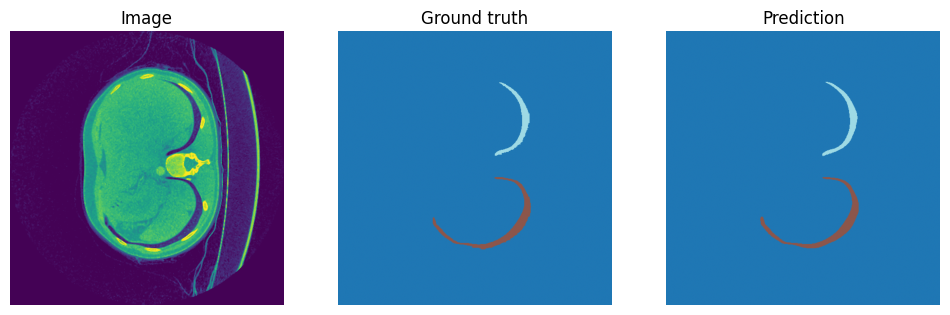

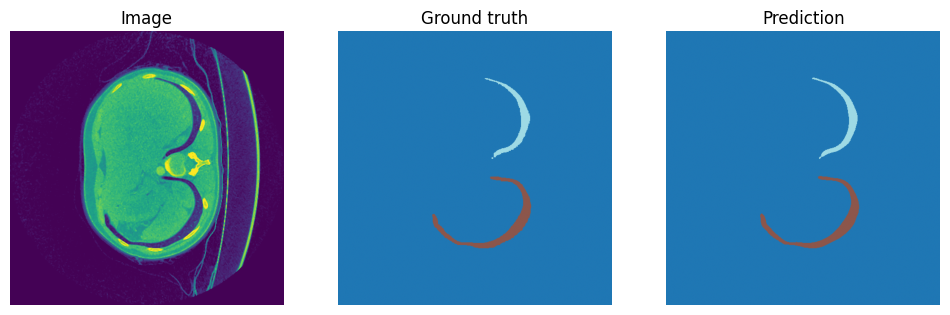

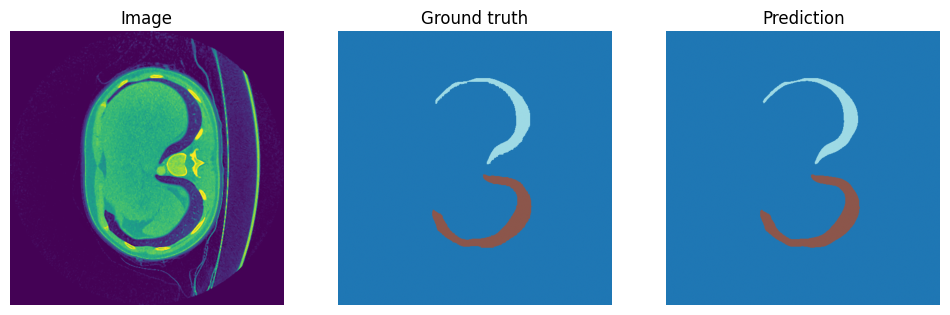

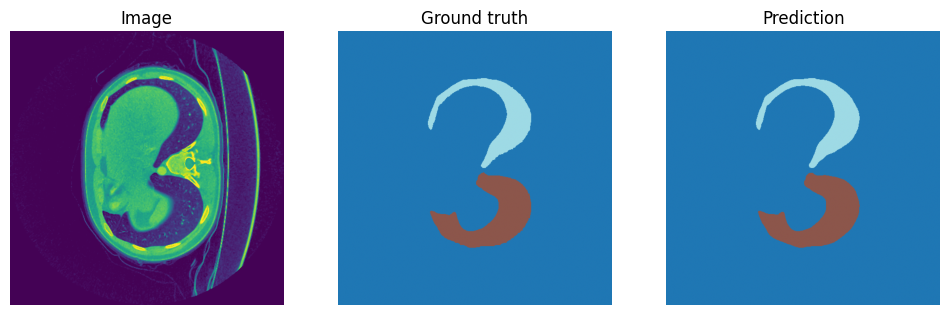

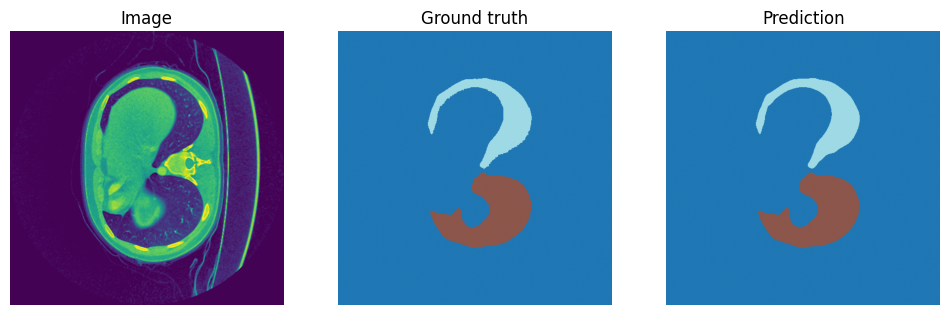

In [16]:
import numpy as np


# Fetch a batch from the test loader
images, masks = data['volume'].unsqueeze(1), data['mask']
# Switch the model to evaluation mode
with torch.inference_mode():
    model.eval()
    logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break

### Pendências:

* Código para KFold;
* Pensar fluxo comparativo;